In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.dataloader import MNISTDataLoader

d:\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MNIST_dataset = MNISTDataLoader(batch_size, transform_mode="[0,1]")
MNIST_training_set = MNIST_dataset.get_dataloader(train=True)#, number=5)

In [5]:
def reconstruction_error(X, X_re):
    return torch.mean((X - X_re) ** 2)

# PCA

In [12]:
images = torch.tensor([])
labels = torch.tensor([])
for X, Y in MNIST_training_set:
    images = torch.cat((images, X.reshape(-1, 28 * 28)))
    labels = torch.cat((labels, Y)) 
images.shape, labels.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [35]:
from models.VAE.autoencoder import PCA

pca = PCA()
pca.fit(images)

In [22]:
dim = 10
images_re = pca(images, dim)
reconstruction_error(images, images_re)

tensor(0.0296)

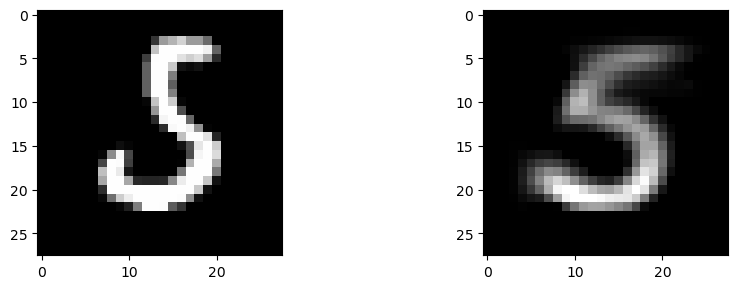

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

idx = 20
X_show = [images[idx], images_re[idx]]

for i in range(2):
    axes[i].imshow(
        1 * X_show[i].reshape(28, 28).detach().numpy(), vmin=0, vmax=1, cmap="gray"
    )
    #axes[i].axis("off")

plt.tight_layout()
plt.show()

# Autoencoders

In [7]:
# training process
def train(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    for _ in range(epoch):
        for X, _ in dataloader:
            X = X.reshape(-1, 28*28).to(device)
            X_re, _ = model(X)
            loss = loss_fn(X_re, X)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(loss.item())

In [9]:
# MLP_AE
import importlib
import models.VAE.autoencoder
importlib.reload(models.VAE.autoencoder)

from models.VAE.autoencoder import MLP_AE

mlp_ae = MLP_AE(28*28, 10).to(device)

In [10]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_ae.parameters(), lr=0.001)
train(MNIST_training_set, mlp_ae, loss, optimizer, 20)

0.11134860664606094
0.11046892404556274
0.10177460312843323
0.0890917256474495
0.08374479413032532
0.07742640376091003
0.07448579370975494
0.06670869886875153
0.0670577734708786
0.06789202243089676
0.06954531371593475
0.06706701219081879
0.07105351984500885
0.07053808122873306
0.06746593862771988
0.06617537885904312
0.06636005640029907
0.06306873261928558
0.06589041650295258
0.06997249275445938
0.06648855656385422
0.06647250801324844
0.06794781237840652
0.06444234400987625
0.06418301910161972
0.06195477768778801
0.06480364501476288
0.06490171700716019
0.06366036832332611
0.060625433921813965
0.0595884695649147
0.06304936110973358
0.061509840190410614
0.06164916604757309
0.06129243224859238
0.06199271231889725
0.0612562894821167
0.05970710515975952
0.05886412411928177
0.05928896740078926
0.057330433279275894
0.05815137177705765
0.056068211793899536
0.05710659921169281
0.0561271570622921
0.05604344978928566
0.055911142379045486
0.055865246802568436
0.05511512607336044
0.05363121256232262

In [ ]:
images = images.to(device)
images_re_mlpae, z = mlp_ae(images)
reconstruction_error(images, images_re_mlpae)

tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>)

In [22]:
z[0].detach()

tensor([ 2.5736,  1.5307, -0.9258, -0.9032,  0.3501, -1.7979, -0.2111,  1.0916,
         0.6066, -0.9675], device='cuda:0')

tensor(7.)


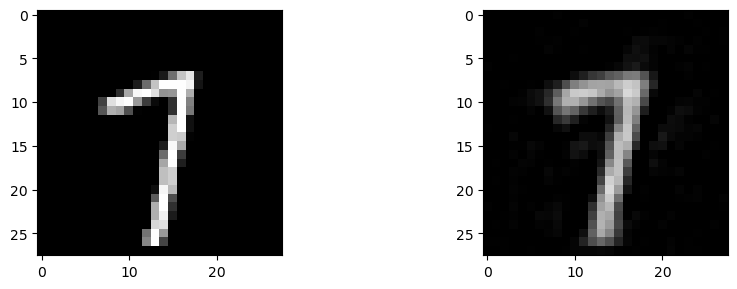

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

idx = 42
print(labels[idx])
X_show = [images.to("cpu")[idx], images_re_mlpae.to("cpu")[idx]]

for i in range(2):
    axes[i].imshow(
        1 * X_show[i].reshape(28, 28).detach().numpy(), vmin=0, vmax=1, cmap="gray"
    )
    # axes[i].axis("off")

plt.tight_layout()
plt.show()

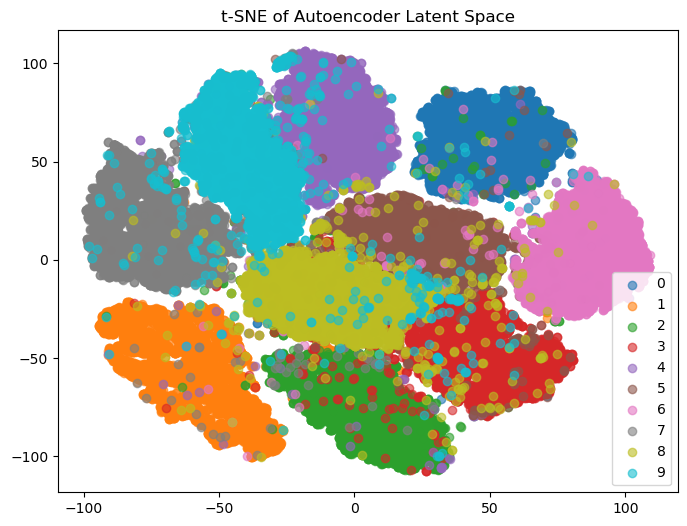

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(z.cpu().detach().numpy())

plt.figure(figsize=(8, 6))
for i in range(10):
    idx = labels == i
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=str(i), alpha=0.6)
plt.legend()
plt.title("t-SNE of Autoencoder Latent Space")
plt.show()